In [1]:
import csv
import tqdm
import torch
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Convert data to PyTorch DataLoader
class CustomDataset(Dataset):
    def __init__(self, data, labels, noise_factor, std_dev):
        self.data = data
        self.labels = labels
        self.noise_factor = noise_factor
        self.std_dev = std_dev

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]   

        # Add random noise to the item
        noisy_item = item * random.gauss(1, self.std_dev) + torch.randn_like(item) * self.noise_factor

        return noisy_item, label

In [3]:
# Define the MLP model
class CustomModule(nn.Module):
    def __init__(self, input_size, output_size):
        super(CustomModule, self).__init__()
        layers = [
            nn.Linear(input_size, output_size),
            nn.LayerNorm(output_size),
            nn.GELU(),
            nn.Dropout(0.25),
        ]
        
        self.module = nn.Sequential(*layers)

    def forward(self, x):
        return self.module(x)
    
class Backbone(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_experts):
        super(Backbone, self).__init__()
        
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.num_experts = num_experts

        self.drop_input = nn.Dropout(0.01)

        self.input_layer = CustomModule(self.input_size, self.hidden_sizes[0])
        self.layers, self.gates = self._build_layers()

    def _build_layers(self):
        layers = []
        gates = []

        for i in range(len(self.hidden_sizes) - 1):
            layers.append(nn.Sequential(*[CustomModule(self.hidden_sizes[i], self.hidden_sizes[i + 1]) for _ in range(self.num_experts)]))
            gates.append(nn.Sequential(
                nn.Linear(self.hidden_sizes[i], self.num_experts),
                nn.Softmax(dim=1)
            ))

        layers = nn.Sequential(*layers)
        gates = nn.Sequential(*gates)

        return layers, gates

    def forward(self, x):
        x = self.drop_input(x)
        x = self.input_layer(x)
        for gate, layer in zip(self.gates, self.layers):
            expert_weights = gate(x).permute(1, 0)
            expert_outputs = [layer[i](x) for i in range(self.num_experts)]
            x = sum(expert_weight.unsqueeze(1) * expert_output for expert_weight, expert_output in zip(expert_weights, expert_outputs))
        return x
        

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, num_experts=12):
        super(MLP, self).__init__()
        self.backbone = Backbone(input_size, hidden_sizes, num_experts)
        
        self.output_layer = nn.Sequential(
            nn.Linear(hidden_sizes[-1], output_size),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.output_layer(x)
        return x

In [4]:
def calculate_class_weights(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    num_classes = len(unique_classes)

    class_weights = []
    for i, class_label in enumerate(unique_classes):
        class_weight = total_samples / (num_classes * class_counts[i])
        class_weights.append(class_weight)

    return class_weights

In [5]:
depression_embeds = np.load("/kaggle/input/depression-embeds/depression_embed.npy")

tweet_df = pd.read_csv("/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv")
depression_label = tweet_df["label (depression result)"].to_numpy()

In [6]:
rng = np.random.default_rng(seed=0)

permuted = rng.permutation(len(depression_embeds))
shuffled_x, shuffled_class = depression_embeds[permuted], depression_label[permuted]

train_prop = 0.40
val_prop = 0.30

n_train = int(len(shuffled_x) * train_prop)
n_val = int(len(shuffled_x) * val_prop)

train_x, train_y = shuffled_x[:n_train], shuffled_class[:n_train]
validation_x, validation_y = shuffled_x[n_train:n_train+n_val], shuffled_class[n_train:n_train+n_val]
test_x, test_y = shuffled_x[n_train+n_val:], shuffled_class[n_train+n_val:]

print(f"Train set : {len(train_x)} samples")
print(f"Val set  : {len(validation_x)} samples")
print(f"Test set  : {len(test_x)} samples")

train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
validation_x = torch.tensor(validation_x, dtype=torch.float32)
validation_y = torch.tensor(validation_y, dtype=torch.float32)
test_x = torch.tensor(test_x, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

train_dataset = CustomDataset(train_x, train_y, noise_factor=0.005, std_dev=0.4)
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

validation_dataset = CustomDataset(validation_x, validation_y, noise_factor=0, std_dev=0)
validation_loader = DataLoader(validation_dataset, batch_size=1024, shuffle=False)

test_dataset = CustomDataset(test_x, test_y, noise_factor=0, std_dev=0)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

Train set : 4125 samples
Val set  : 3094 samples
Test set  : 3095 samples


In [7]:
device = "cuda" if torch.cuda.is_available else "cpu"

emotion_model_state_dict = torch.load("/kaggle/input/d/razvangeorgecostea/model-emotion-450k-v2/model_emotion_450k_V2.pth")

input_size = 4096
hidden_sizes = [8192, 256, 32]
output_size = 2
num_epochs = 5

# Loss function for multi-label classification with weighted cross-entropy
weights = torch.tensor(calculate_class_weights(train_y), dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.2)

# MLP Classifier
emotion_model = MLP(input_size, hidden_sizes, 6)
emotion_model.load_state_dict(emotion_model_state_dict)

depression_model = MLP(input_size, hidden_sizes, output_size)
depression_model.backbone = emotion_model.backbone
depression_model.to(device)

# Optimizer (AdamW)
optimizer = optim.AdamW(depression_model.parameters(), lr=1e-4, weight_decay=2)

# Learning rate scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

  0%|          | 0/11 [00:00<?, ?it/s]

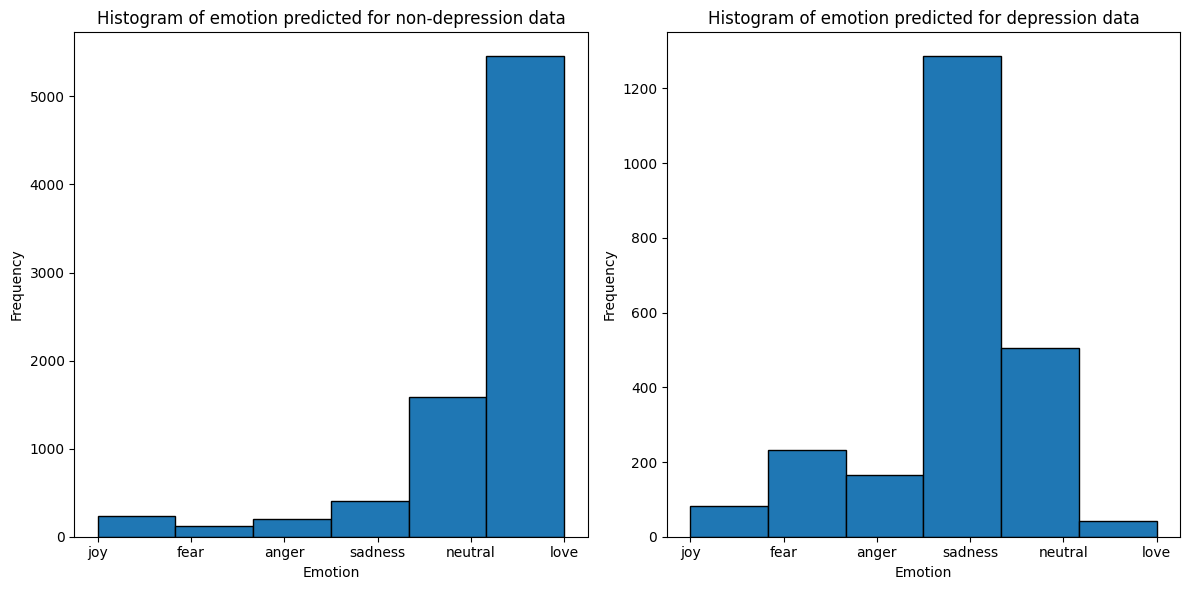

In [8]:
tensor_embeds = torch.tensor(depression_embeds, dtype=torch.float32)
tensor_label = torch.tensor(depression_label, dtype=torch.float32)

all_depression_data = CustomDataset(tensor_embeds, tensor_label, noise_factor=0, std_dev=0)
all_depression_loader = DataLoader(all_depression_data, batch_size=1024, shuffle=False)

emotion_model.to(device)
emotion_model.eval()
no_batches = len(all_depression_loader)
total_targets = []
total_predictions = []

for inputs, targets in tqdm(all_depression_loader, total=no_batches):
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = emotion_model(inputs)
        targets = targets.to(torch.int64)

        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        total_predictions.extend(predictions.cpu().numpy())
        total_targets.extend(targets.cpu().numpy())

# Convert predictions and targets to numpy arrays
total_predictions = np.array(total_predictions)
total_predictions = total_predictions.reshape([total_predictions.shape[0], 1])

test_targets = np.array(total_targets)
test_targets = test_targets.reshape([test_targets.shape[0], 1])

emotions = np.hstack([total_predictions, test_targets])

non_depression_emotions = emotions[emotions[:, 1] == 0][:, 0]
depression_emotions = emotions[emotions[:, 1] == 1][:, 0]

emotion_labels = ['joy', 'fear', 'anger', 'sadness', 'neutral', 'love']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(non_depression_emotions, bins=6, edgecolor="black")
plt.xticks(np.arange(6), emotion_labels)
plt.title("Histogram of emotion predicted for non-depression data")
plt.xlabel("Emotion")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(depression_emotions, bins=6, edgecolor="black")
plt.xticks(np.arange(6), emotion_labels)
plt.title("Histogram of emotion predicted for depression data")
plt.xlabel("Emotion")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [9]:
def train_step(data_loader, model, optimizer, criterion, scheduler):
    train_step_loss, train_step_acc = 0.0, 0.0
    no_batches = len(data_loader)
    total_targets = []
    total_predictions = []
    
    for inputs, targets in tqdm(data_loader, total=no_batches):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        targets = targets.to(torch.int64)
        
        loss = criterion(outputs, targets)
        train_step_loss += loss.item()
        
        predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
        total_predictions.extend(predictions.cpu().numpy())
        total_targets.extend(targets.cpu().numpy())
        
        loss.backward()
        
        optimizer.step()
        scheduler.step()  
        
    train_step_loss /= no_batches
    train_step_acc = accuracy_score(total_targets, total_predictions)
    
    return train_step_loss, train_step_acc

def valid_step(data_loader, model, optimizer, criterion):
    valid_step_loss, valid_step_acc = 0.0, 0.0
    no_batches = len(data_loader)
    total_targets = []
    total_predictions = []
    
    for inputs, targets in tqdm(data_loader, total=no_batches):
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.no_grad():
            outputs = model(inputs)
            targets = targets.to(torch.int64)

            loss = criterion(outputs, targets)
            
            valid_step_loss += loss.item()
            
            predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            total_predictions.extend(predictions.cpu().numpy())
            total_targets.extend(targets.cpu().numpy())
        
        
    valid_step_loss /= no_batches
    valid_step_acc = accuracy_score(total_targets, total_predictions)
    
    return valid_step_loss, valid_step_acc

def run():
    loss = {
            "train": [],
            "valid": [],
    }
    acc = {
        "train": [],
        "valid": [],
    }
    
    epochs_indices = range(1, num_epochs+1)
    best_acc = 0.0
    best_model = MLP(input_size, hidden_sizes, output_size).to(device)
        
    for epoch in epochs_indices:
        print("Epoch: ", epoch)
        
        depression_model.train()
        train_loss_epoch, train_acc_epoch = train_step(train_loader, depression_model, optimizer, criterion, scheduler)
        loss["train"].append(train_loss_epoch)
        acc["train"].append(train_acc_epoch)
        
        depression_model.eval()
        valid_loss_epoch, valid_acc_epoch = valid_step(validation_loader, depression_model, optimizer, criterion)
        loss["valid"].append(valid_loss_epoch)
        acc["valid"].append(valid_acc_epoch)
        
        print(f"Train accuracy: {train_acc_epoch:.4f}   |   Train loss: {train_loss_epoch:.4f}")
        print(f"Valid accuracy: {valid_acc_epoch:.4f}   |   Valid loss: {valid_loss_epoch:.4f}")
        
        if valid_acc_epoch > best_acc:
            best_acc = valid_acc_epoch
            best_model.load_state_dict(depression_model.state_dict())
        
    # Plot loss
    plt.plot(epochs_indices, loss["train"])
    plt.plot(epochs_indices, loss["valid"])
    plt.title("Loss")
    plt.show()
    
    # Plot accuracy
    plt.plot(epochs_indices, acc["train"])
    plt.plot(epochs_indices, acc["valid"])
    plt.title("Accuracy")
    plt.show()
    
    return best_model

Epoch:  1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train accuracy: 0.8992   |   Train loss: 0.5866
Valid accuracy: 0.9855   |   Valid loss: 0.5204
Epoch:  2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train accuracy: 0.9699   |   Train loss: 0.5085
Valid accuracy: 0.9961   |   Valid loss: 0.4933
Epoch:  3


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train accuracy: 0.9884   |   Train loss: 0.4754
Valid accuracy: 0.9948   |   Valid loss: 0.4688
Epoch:  4


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train accuracy: 0.9869   |   Train loss: 0.4835
Valid accuracy: 0.9948   |   Valid loss: 0.4616
Epoch:  5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train accuracy: 0.9867   |   Train loss: 0.4990
Valid accuracy: 0.9968   |   Valid loss: 0.4557


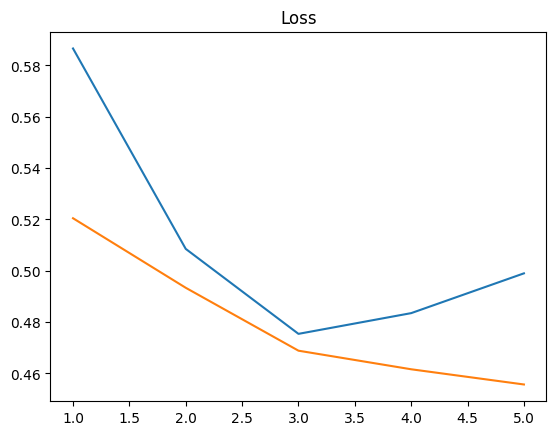

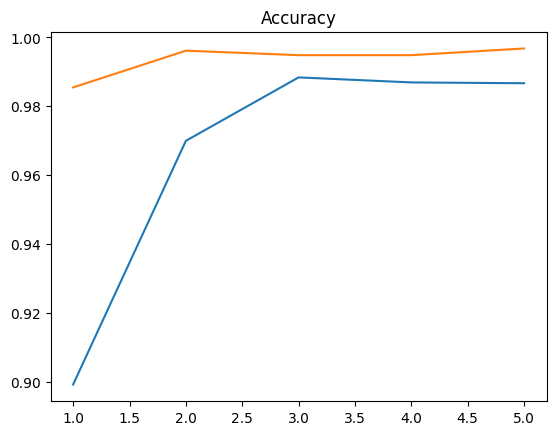

In [10]:
best_model = run()

  0%|          | 0/4 [00:00<?, ?it/s]

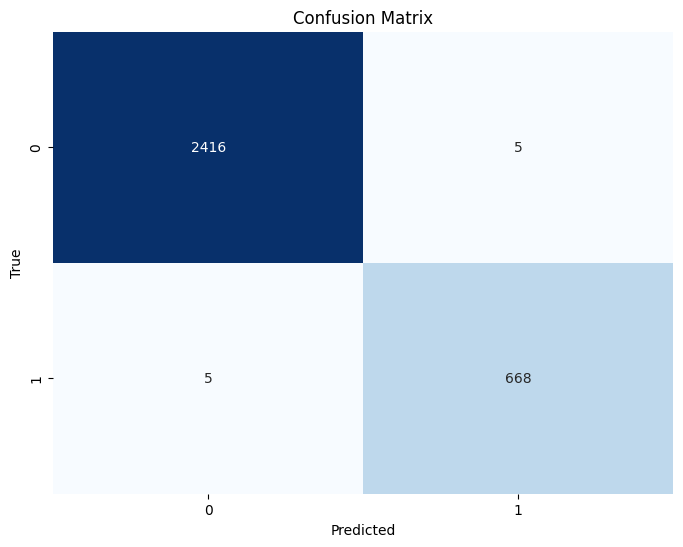

Final Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2421
           1       0.99      0.99      0.99       673

    accuracy                           1.00      3094
   macro avg       1.00      1.00      1.00      3094
weighted avg       1.00      1.00      1.00      3094



  0%|          | 0/4 [00:00<?, ?it/s]

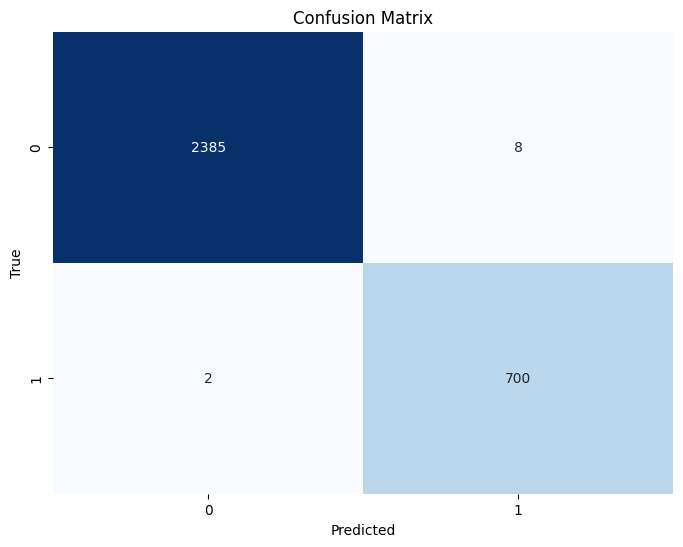

Final Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2393
           1       0.99      1.00      0.99       702

    accuracy                           1.00      3095
   macro avg       0.99      1.00      1.00      3095
weighted avg       1.00      1.00      1.00      3095



In [11]:
# Generate a final classification report
for data_loader in [validation_loader, test_loader]:
    best_model.eval()
    no_batches = len(data_loader)
    total_targets = []
    total_predictions = []

    for inputs, targets in tqdm(data_loader, total=no_batches):
        inputs, targets = inputs.to(device), targets.to(device)

        with torch.no_grad():
            outputs = best_model(inputs)
            targets = targets.to(torch.int64)

            predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
            total_predictions.extend(predictions.cpu().numpy())
            total_targets.extend(targets.cpu().numpy())

    # Convert predictions and targets to numpy arrays
    total_predictions = np.array(total_predictions)
    validation_targets = np.array(total_targets)

    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(validation_targets, total_predictions)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    # Generate a classification report
    report = classification_report(validation_targets, total_predictions)
    print("Final Classification Report:\n", report)